In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from transform import Transform
import sys
import warnings

In [6]:
def MAPE(y_true, y_pred):
    assert len(y_true) == len(y_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    return np.sum(np.abs((y_true - y_pred) / y_pred)) / n

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
df = pd.read_csv('../data/train.csv')

In [9]:
df['ds'] = pd.to_datetime(df['ds'], infer_datetime_format=True)
df = df.set_index('ds')

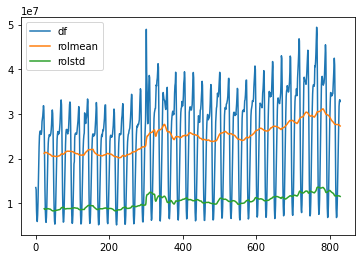

In [10]:
rolmean = df.rolling(window=24).mean()
rolstd = df.rolling(window=24).std()

plt.plot(range(df.shape[0]), df.y)
plt.plot(range(rolmean.shape[0]), rolmean.y)
plt.plot(range(rolstd.shape[0]), rolstd.y)
plt.legend(['df', 'rolmean', 'rolstd'])

### Preprocessing and stationarity evaluation

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def transform_analysis(df, transform, plot=False):
    df = df.copy()
    df.y = transform(df.y)
    rolmean = df.rolling(window=24).mean()
    rolstd = df.rolling(window=24).std()
    
    if (plot):
        f, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].plot(range(df.shape[0]), df.y)
        ax[0].plot(range(df.shape[0]), rolmean)
        ax[0].legend(['df', 'rolmean', 'rolstd'])

        ax[1].plot(range(df.shape[0]), rolstd)
        ax[1].legend(['rolstd'])
        plt.show()
    
    _, pvalue, _, _, _, _ = adfuller(df, autolag='AIC')
    return pvalue

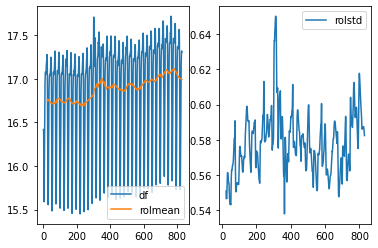

Log pvalue:  0.7519408681945678


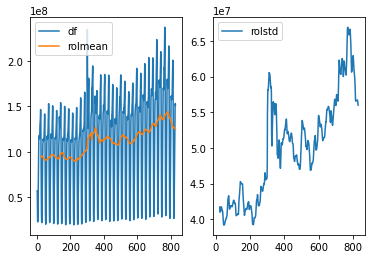

Boxcox pvalue:  0.7115405615785333


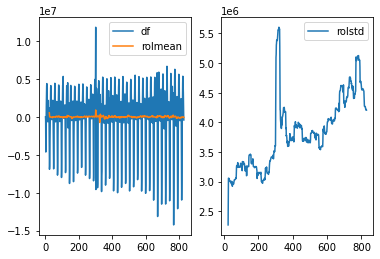

Diff pvalue:  0.0


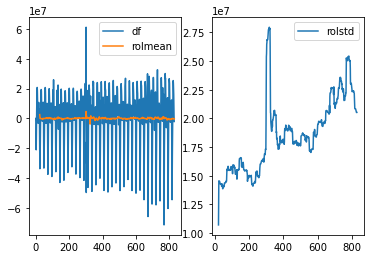

Boxcox+diff pvalue:  0.0


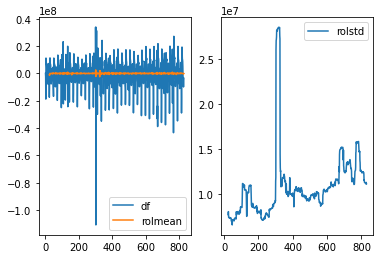

Boxcox+diff2 pvalue:  0.0


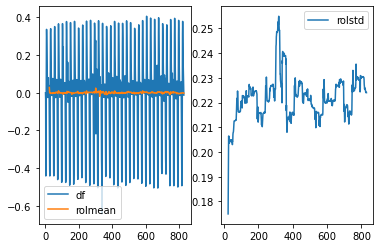

Log+diff pvalue:  0.0


In [13]:
print('Log pvalue: ', transform_analysis(df, Transform.transform_log, plot=True))
print('Boxcox pvalue: ', transform_analysis(df, Transform.transform_boxcox_ignore, plot=True))
print('Diff pvalue: ',transform_analysis(df, Transform.transform_diff, plot=True))
print('Boxcox+diff pvalue: ',transform_analysis(df, Transform.transform_boxcox_diff_ignore, plot=True))
print('Boxcox+diff2 pvalue: ',transform_analysis(df, Transform.transform_boxcox_diff2_ignore, plot=True))
print('Log+diff pvalue: ',transform_analysis(df, Transform.transform_log_diff, plot=True))

### Train

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
TEST_SIZE = 70
TRAIN_SIZE = df.shape[0] - TEST_SIZE

y0 = Transform.transform_log(df.y)[0]
df_transformed = df.copy()
df_transformed.y = Transform.transform_log_diff(df.y)
df_train = df_transformed[:TRAIN_SIZE]
df_test = df_transformed[TRAIN_SIZE:]

d = 0
inv_func = Transform.inv_transform_log_diff
params_pdq = (2, d, 2)

In [16]:
model = ARIMA(df_train, order=params_pdq).fit()

/home/artem/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/artem/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/artem/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [17]:
arima_predict = model.predict(start=TRAIN_SIZE, end=TRAIN_SIZE + TEST_SIZE - 1)

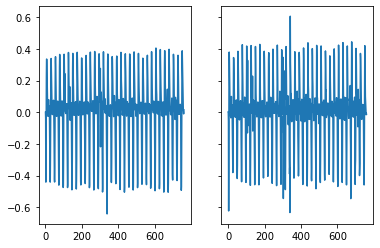

In [18]:
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].plot(range(TRAIN_SIZE), df_transformed.y[:TRAIN_SIZE])
ax[1].plot(range(TRAIN_SIZE), model.fittedvalues)

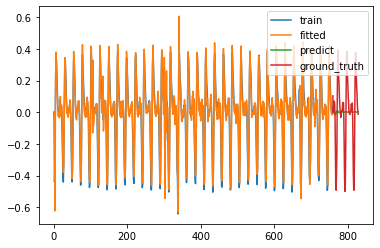

In [19]:
plt.plot(range(TRAIN_SIZE), df_transformed.y[:TRAIN_SIZE])
plt.plot(range(TRAIN_SIZE), model.fittedvalues)
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), arima_predict)
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), df_test.y)
plt.legend(['train', 'fitted', 'predict', 'ground_truth'])
plt.show()

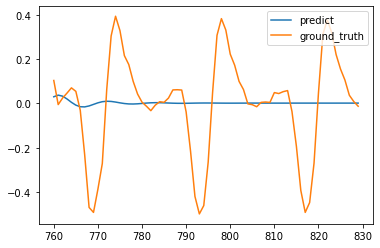

In [20]:
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), arima_predict)
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), df_test.y)
plt.legend(['predict', 'ground_truth'])
plt.show()

In [23]:
MAPE(inv_func(df_test.y, y0), inv_func(arima_predict, y0))

0.33803323004068336

In [62]:
def model_analysis(transform, inv_transform, params_pdq, plot=False, **kwargs):
    TEST_SIZE = 70
    TRAIN_SIZE = df.shape[0] - TEST_SIZE

    df_transformed = df.copy()
    df_transformed.y = transform(df.y)
    df_train = df_transformed[:TRAIN_SIZE]
    df_test = df_transformed[TRAIN_SIZE:]

    model = ARIMA(df_train, order=params_pdq, freq='H').fit()
    arima_predict = model.predict(start=TRAIN_SIZE, end=TRAIN_SIZE + TEST_SIZE - 1, freq='H')
    
    if (plot):
        f, ax = plt.subplots(nrows=2, ncols=2, sharey=True)

        ax[0][0].plot(range(TRAIN_SIZE), df_transformed.y[:TRAIN_SIZE])
        ax[0][0].legend(['train'])
        ax[0][1].plot(range(TRAIN_SIZE), model.fittedvalues)
        ax[0][1].legend(['fitted'])

        ax[1][0].plot(range(TRAIN_SIZE), df_transformed.y[:TRAIN_SIZE])
        ax[1][0].plot(range(TRAIN_SIZE), model.fittedvalues)
        ax[1][0].plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), arima_predict)
        ax[1][0].plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), df_test.y)
        ax[1][0].legend(['train', 'fitted', 'predict', 'ground_truth'])

        ax[1][1].plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), arima_predict)
        ax[1][1].plot(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), df_test.y)
        ax[1][1].legend(['predict', 'ground_truth'])

        plt.show()
        
    return MAPE(inv_func(df_test.y, **kwargs), inv_func(arima_predict, **kwargs))

In [64]:
y0 = Transform.transform_log(df.y)[0]

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    for p in range(0, 5):
        for q in range(0, 5):
            params_pdq = (p, 0, q)
            score = model_analysis(Transform.transform_log_diff, Transform.inv_transform_log_diff, params_pdq, y0=y0)
            print(f'Log diff + params_pdq={params_pdq} MAPE: ', score)

Log diff + params_pdq=(0, 0, 0) MAPE:  0.3101148831110528
Log diff + params_pdq=(0, 0, 1) MAPE:  0.31173894016709836
Log diff + params_pdq=(0, 0, 2) MAPE:  0.3177504222104664
Log diff + params_pdq=(0, 0, 3) MAPE:  0.32685236790358524
Log diff + params_pdq=(0, 0, 4) MAPE:  0.33279981826267985
Log diff + params_pdq=(1, 0, 0) MAPE:  0.33892150192135534
Log diff + params_pdq=(1, 0, 1) MAPE:  0.34915389348158826
Log diff + params_pdq=(1, 0, 2) MAPE:  0.35352933769773964
Log diff + params_pdq=(1, 0, 3) MAPE:  0.34950903694451274
Log diff + params_pdq=(1, 0, 4) MAPE:  0.3431443897613789
Log diff + params_pdq=(2, 0, 0) MAPE:  0.33449781018363883
Log diff + params_pdq=(2, 0, 1) MAPE:  0.3342892586845922
Log diff + params_pdq=(2, 0, 2) MAPE:  0.33803323004068336
Log diff + params_pdq=(2, 0, 3) MAPE:  0.34375752601779014
Log diff + params_pdq=(2, 0, 4) MAPE:  0.41178857043780065
Log diff + params_pdq=(3, 0, 0) MAPE:  0.33436519531168796
Log diff + params_pdq=(3, 0, 1) MAPE:  0.334505514808983
Log

/home/artem/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/artem/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


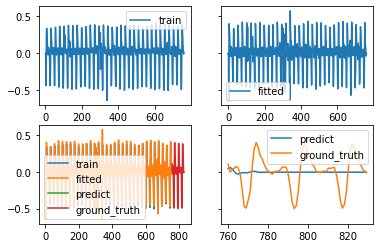

Log diff + params_pdq=(4, 0, 3) MAPE:  0.2955330655125341


In [63]:
y0 = Transform.transform_log(df.y)[0]
params_pdq = (4, 0, 3)
score = model_analysis(Transform.transform_log_diff, Transform.inv_transform_log_diff, params_pdq, plot=True, y0=y0)
print(f'Log diff + params_pdq={params_pdq} MAPE: ', score)